### Long Nguyen

### RANSAC-based Image Stitching



In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torchvision
import kornia as kornia

from PIL import Image
import torchvision.transforms as transforms

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    
# Usage:
# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, computed_inliers)


### PART A with NumPy array

### 1. Preprocessing: Load both images and convert to greyscale

### 2. Detect keypoints and extract descriptors

(2575, 2556, 3)


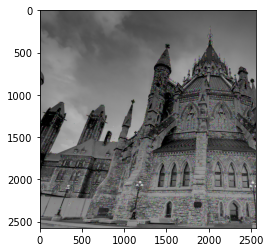

In [3]:
# Left image
left_img = cv.imread('parliament-left.jpg')
left_img_gray= cv.cvtColor(left_img,cv.COLOR_BGR2GRAY)

sift = cv.SIFT_create()
left_key, left_descriptors = sift.detectAndCompute(left_img_gray,None)

left_img_key = cv.drawKeypoints(left_img_gray, left_key, left_img)
cv.imwrite('left_keypoints.jpg',left_img_key)

print(left_img_key.shape)
plt.imshow(left_img_key)

(2400, 2266, 3)


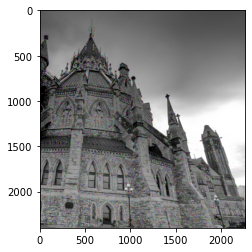

In [4]:
# Right image
right_img = cv.imread('parliament-right.jpg')
right_img_gray = cv.cvtColor(right_img, cv.COLOR_BGR2GRAY)

sift = cv.SIFT_create()
right_key, right_descriptors = sift.detectAndCompute(right_img_gray,None)
# print(right_key)

right_img_key = cv.drawKeypoints(right_img_gray, right_key, right_img)
cv.imwrite('right_keypoints.jpg', right_img_key)

print(right_img_key.shape)
plt.imshow(right_img_key)

### 3. Match Features

### 4. Prune Features

In [5]:
import scipy.spatial

distances = scipy.spatial.distance.cdist(left_descriptors, right_descriptors, 'sqeuclidean')

print(distances)

[[435429. 370575. 366195. ... 312663. 309152. 343451.]
 [315942. 313864. 282870. ... 316282. 308689. 199532.]
 [218332. 273692. 214198. ... 263116. 255899. 205516.]
 ...
 [467149. 434397. 418273. ... 431103. 428284. 416513.]
 [272877. 399971. 337259. ... 281653. 288742. 323697.]
 [289799. 205099. 219523. ... 322497. 332058. 294131.]]


In [6]:
# Select the top 200 descriptor pairs with the smallest pairwise distances
num_inliers = 200
matches = np.argpartition(distances.flatten(), num_inliers)[:num_inliers]
matches = np.unravel_index(matches, distances.shape)

# Retrieve the corresponding keypoints from left and right images
inliers = np.zeros((num_inliers, 4))
for i, (m, n) in enumerate(zip(matches[0], matches[1])):
    inliers[i] = np.hstack((left_key[m].pt, right_key[n].pt))
    

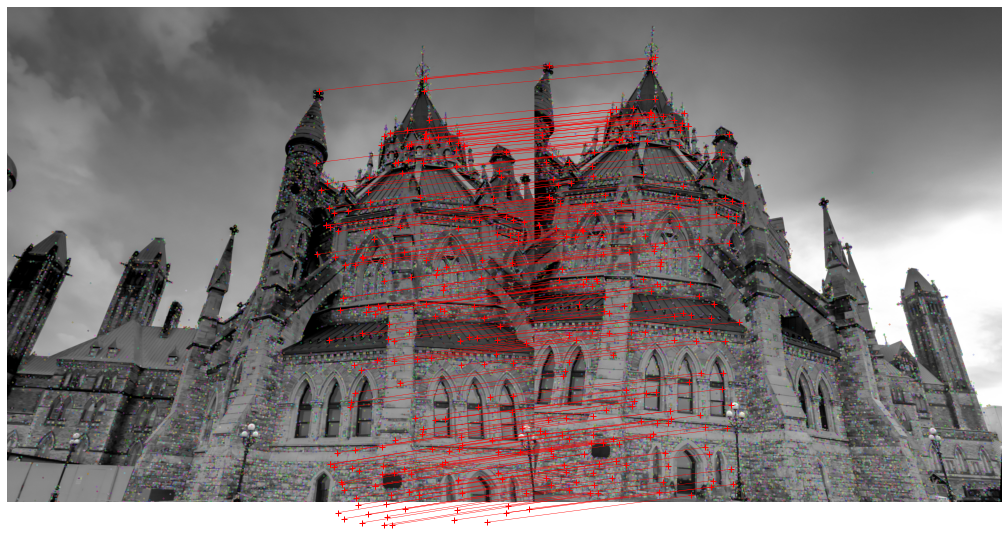

In [7]:
# Plot the inlier matches
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, left_img[0:2400,0:2556,0:3], right_img, inliers)

# Has to be indexed, or the dimensions wont match

### 5. Robust Transformation estimation

In [8]:
import random 

# Define RANSAC parameters
num_inliers = 4  # Minimum number of pairwise matches to estimate affine transformation
iterations = 100  # Number of RANSAC iterations
threshold = 1.5  # Matching threshold in pixels

# RANSAC to estimate affine transformation
max_inliers = -1
for i in range(iterations):
    # Select 4 random descriptor pairs
    sample = random.sample(list(range(len(matches[0]))), num_inliers)

    # Calculate affine transformation from sample
    src = np.float32([inliers[sample[i], 0:2] for i in range(num_inliers)]).reshape(-1, 1, 2)
    dst = np.float32([inliers[sample[i], 2:4] for i in range(num_inliers)]).reshape(-1, 1, 2)
    affine_transform, _ = cv.estimateAffinePartial2D(src, dst)

    # Calculate inliers based on threshold
    transformed_points = cv.transform(np.float32([inliers[:, 0:2]]), affine_transform).squeeze()
    distances = np.sqrt(np.sum((transformed_points - inliers[:, 2:4])**2, axis=1))
    inlier_mask = distances < threshold

    # Update maximum number of inliers
    num_inliers_curr = np.sum(inlier_mask)
    if num_inliers_curr > max_inliers:
        max_inliers = num_inliers_curr
        best_affine_transform = affine_transform
        best_inliers = inliers[inlier_mask]
        
# Add the last element to the matrix
best_affine_transform = np.vstack((best_affine_transform, [0, 0, 1]))

# Print Transformation Matrix
print("Number of pairwise matches:")
print(num_inliers)
print("Number of RANSAC iterations:")
print(iterations)
print("Threshold:")
print(threshold)
print("Number of Inliers:")
print(max_inliers)
print('Transformation Matrix: ')
print(best_affine_transform)

Number of pairwise matches:
4
Number of RANSAC iterations:
100
Threshold:
1.5
Number of Inliers:
200
Transformation Matrix: 
[[ 9.78480579e-01 -5.11710929e-02 -1.38798242e+03]
 [ 5.11710929e-02  9.78480579e-01 -1.94999813e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### 6. Compute Optimal Transformation

In [9]:
# Compute optimal transformation using least-squares
src = np.float32([best_inliers[:, 0:2]])
dst = np.float32([best_inliers[:, 2:4]])
optimal_transform, _ = cv.estimateAffinePartial2D(src, dst)

# Add the last element to the matrix
optimal_transform = np.vstack((optimal_transform, [0, 0, 1]))

# Print Transformation Matrix
print('Optimal Transformation Matrix: ')
print(optimal_transform)


Optimal Transformation Matrix: 
[[ 9.78252613e-01 -5.12712125e-02 -1.38737386e+03]
 [ 5.12712125e-02  9.78252613e-01 -1.94868766e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### 7. Create Panorama

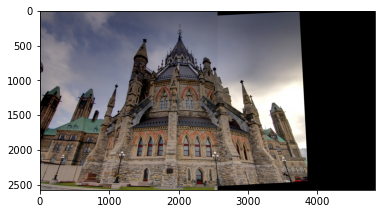

In [13]:
from skimage.transform import ProjectiveTransform, warp

# Load images
left_img = cv.imread('parliament-left.jpg')
right_img = cv.imread('parliament-right.jpg')
left_img = left_img.astype(np.float32)/255;
right_img = right_img.astype(np.float32)/255;

# Convert color channels to the correct order
left_img = cv.cvtColor(left_img, cv.COLOR_BGR2RGB)
right_img = cv.cvtColor(right_img, cv.COLOR_BGR2RGB)

# Define the homography matrix
homography_matrix = optimal_transform

# Define the output shape of the panorama
output_shape = (left_img.shape[0], left_img.shape[1] + right_img.shape[1])

# Define the ProjectiveTransform
projective_transform = ProjectiveTransform(matrix=homography_matrix)

# Warp the right image onto the left image using the ProjectiveTransform
panorama = warp(right_img, projective_transform, output_shape=output_shape)

# Blend the left and warped right image to create the panorama
panorama[:, :left_img.shape[1], :] = left_img

cv.imwrite('Panorama.jpg', panorama)
plt.imshow(panorama)